In [19]:
# Author: Henrik Pettersson

In [20]:
# Standard imoprts
import numpy as np
import matplotlib.pyplot as plt
#
from scipy.optimize import minimize
#
from qiskit.quantum_info import SparsePauliOp
#
from qiskit.circuit.library import QAOAAnsatz

#
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#
from qiskit_aer import AerSimulator
#
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import SamplerV2 as Sampler

print('import done')

import done


In [ ]:
# define 'helper functions'
# problem defining Parameters
num_qbits = 2
h1,h2,J = -1/2,0,1/2
def build_problem_paulis() -> list[tuple[str, float]]:
    pauli_list = []
    pauli_list.append(('IZ',h1))
    pauli_list.append(('ZI',h2))
    pauli_list.append(('ZZ',J))

    return pauli_list

# Estimate the cost of a given configuration
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs
    return cost

# classic evaluator
def solution_value(solution_string :str):
    value = 0
    if solution_string[0] == '1':
        value += h1
    if solution_string[1] == '1':
        value += h2
    if solution_string[0] == '1' and solution_string[1] == '1':
        value += J
    return value

In [22]:
# Create 'edge-paulis' pauli operators coresponding to measuring/cutting an edge 
problem_paulis = build_problem_paulis()

# Create cost-hamiltonian from the 'edge-paulis'
cost_hamiltonian = SparsePauliOp.from_list(problem_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IZ', 'ZI', 'ZZ'],
              coeffs=[-0.5+0.j,  0. +0.j,  0.5+0.j])


In [23]:
print(problem_paulis)

[('IZ', -0.5), ('ZI', 0), ('ZZ', 0.5)]


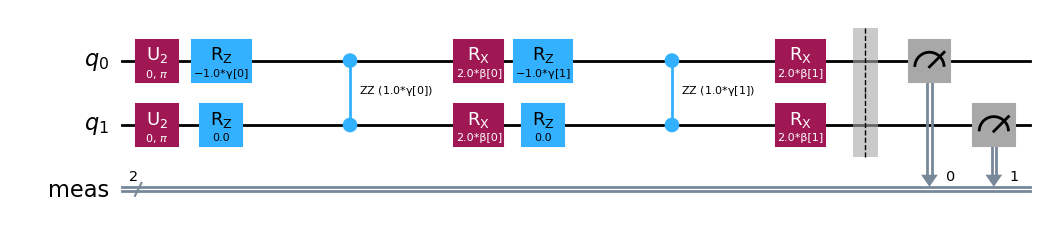

In [58]:
# Layers used in QAOA algorithm, use 1 for simple sweep,
#  more layers may give better results but reqyires more parameters and some tweeking in the code
layers=2
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
sweep_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()

# Show the abstract QAOA circut
circuit.draw('mpl')

# Show the QAOA circuit in terms of simple gates
circuit.decompose().decompose().draw('mpl')

In [ ]:
# Sweep over a single layer of beta and gamma to see the single layer landscape

sim = AerSimulator()
# transpile the abstract circuit to a circuit that fit the simulator/machine
ansatz = transpile(sweep_circuit, sim, optimization_level=0)
# circuit parameters
estimator = Estimator()
hamiltonian = cost_hamiltonian

# Resolution of gamma and beta. larger number = finer resolution/more samples
# Note: aproximate time to run this cell on my machine 
# 100x100 takes ca "long time"
# 40x40   takes ca 24 sec
# 20x20   takes ca 9 sec
# 10x10   takes ca 3 sec
n_gamma = 40+2
n_beta = 40
# gamma, beta \in [0,pi] 

gammas = np.linspace(0, np.pi, num=n_gamma)
betas = np.linspace(0, np.pi, num=n_beta)

cost_values = np.zeros((n_gamma,n_beta))

# Ridiculusly high initial value to start the search for minima
# format (cost, [gamma, beta])
min_solution = (10**9,[-1,-1])

# Sweep over gamma and beta and compute the expected cost for each configuration
for ig in range(n_gamma):
    for jb in range(n_beta):
        gamma = gammas[ig]
        beta = betas[jb]
        params = [gamma, beta]#, gamma, beta]
        cost_values[ig,jb] = cost_func_estimator(params, ansatz, hamiltonian, estimator)
        
        # keep track of minimal solutions for later
        if cost_values[ig,jb] < min_solution[0]:
            min_solution = (cost_values[ig,jb],params)

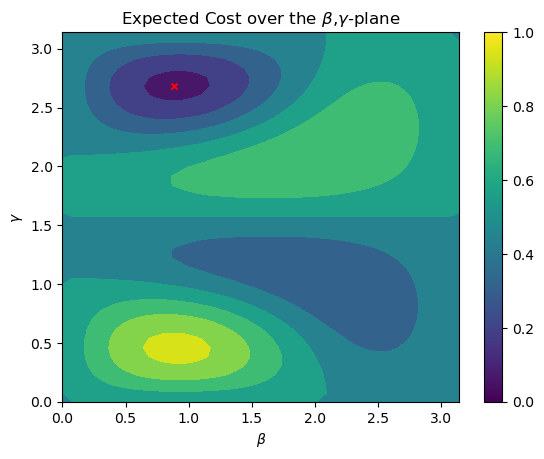

In [66]:
#plotting The result beta gamma sweep

# plot Contours of the expected cost function in the beta gamma plane
# lower values corespond to a better solution
plt.contourf(betas, gammas, cost_values)
cost_min = min_solution[0]
gamma_min,beta_min = min_solution[1]
plt.scatter(beta_min,gamma_min, s=20, c='red',marker='x')
#ax.set_xlim(0, np.pi)
#ax.set_ylim(0, np.pi)

plt.colorbar()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title(r'Expected Cost over the $\beta$,$\gamma$-plane')

plt.show()

In [25]:

sim = AerSimulator()
# transpile the abstract circuit to a circuit that fit the simulator/machine
ansatz = transpile(circuit, sim, optimization_level=0)
# circuit parameters
estimator = Estimator()
hamiltonian = cost_hamiltonian

# Resolution of gamma and beta. larger number = finer resolution/more samples
# Note: aproximate time to run this cell on my machine 
# 100x100 takes ca 4317 min
# 40x40   takes ca 3 min
# 20x20   takes ca 30 sec
# 10x10   takes ca 10 sec
n_gamma1 = 3+1
n_beta1 = 3
n_gamma2 = 3+2
n_beta2 = 3+3
# gamma, beta \in [0,pi] 
# Note: max-cut has a symetry so that [0, pi/2] is suficient
gammas1 = np.linspace(0, np.pi, num=n_gamma1)
betas1 = np.linspace(0, np.pi, num=n_beta1)
gammas2 = np.linspace(0, np.pi, num=n_gamma2)
betas2= np.linspace(0, np.pi, num=n_beta2)

iter = 0
total_iter = n_gamma1 * n_beta1 * n_gamma2 * n_beta2
# Ridiculusly high initial value to start the search for minima
# format (cost, [gamma, beta])
min_solution = {'init_param' : [], 'opt_param' : [], 'opt_value' : 10**4}

# Sweep over gamma and beta and compute the expected cost for each optimal configuration
optimized_sols:list[dict]=[]
for ig1 in range(n_gamma1):
    for jb1 in range(n_beta1):
        for ig2 in range(n_gamma2):
            for jb2 in range(n_beta2):
                params = [ gammas1[ig1],betas1[jb1],gammas2[ig2], betas2[jb2]]# TODO: check order of 1 and 2
                # cost_func_estimator(params, ansatz, hamiltonian, estimator)
            
                result = minimize(
                cost_func_estimator,
                params,
                args=(ansatz, cost_hamiltonian, estimator),
                method="COBYLA",
                )
                
                # keep track of minimal solutions for later
                opt_val = result.get('fun')
                opt_param = result.get('x')
                opt_sol_dict = {'init_param' : params,'opt_param' : opt_param, 'opt_value' : opt_val}
                optimized_sols.append(opt_sol_dict)
                
                if min_solution['opt_value'] > opt_val:
                    min_solution = opt_sol_dict
                iter += 1
                print(f'progress = {iter} / {total_iter} = {100*iter/total_iter:.2f}%')
# todo: check opt_sol_dict for clusters and find local minima and attraction domains

# Todo: process min_solution
        

progress = 1 / 360 = 0.28%
progress = 2 / 360 = 0.56%
progress = 3 / 360 = 0.83%
progress = 4 / 360 = 1.11%
progress = 5 / 360 = 1.39%
progress = 6 / 360 = 1.67%
progress = 7 / 360 = 1.94%
progress = 8 / 360 = 2.22%
progress = 9 / 360 = 2.50%
progress = 10 / 360 = 2.78%
progress = 11 / 360 = 3.06%
progress = 12 / 360 = 3.33%
progress = 13 / 360 = 3.61%
progress = 14 / 360 = 3.89%
progress = 15 / 360 = 4.17%
progress = 16 / 360 = 4.44%
progress = 17 / 360 = 4.72%
progress = 18 / 360 = 5.00%
progress = 19 / 360 = 5.28%
progress = 20 / 360 = 5.56%
progress = 21 / 360 = 5.83%
progress = 22 / 360 = 6.11%
progress = 23 / 360 = 6.39%
progress = 24 / 360 = 6.67%
progress = 25 / 360 = 6.94%
progress = 26 / 360 = 7.22%
progress = 27 / 360 = 7.50%
progress = 28 / 360 = 7.78%
progress = 29 / 360 = 8.06%
progress = 30 / 360 = 8.33%
progress = 31 / 360 = 8.61%
progress = 32 / 360 = 8.89%
progress = 33 / 360 = 9.17%
progress = 34 / 360 = 9.44%
progress = 35 / 360 = 9.72%
progress = 36 / 360 = 10.00%


In [26]:
min_param = min_solution['opt_param']

In [ ]:
# Run the optimal configuration found above
sampler = Sampler()
params_min = min_param

isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
# pub = (ansatz, isa_hamiltonian, params_min)
# job = sampler.run([pub])
# results = job.result()[0]
# cost = results.data.evs

########
 
measured_circuit = ansatz
 
noisy_sampler = Sampler()
shots = None # None gives a better distribution estimarion than a small arbitrary number
# The circuit needs to be transpiled to the AerSimulator target

pub = (ansatz, params_min, shots)
job = noisy_sampler.run([pub])
result = job.result()
pub_result = result[0]
result_distribution :dict = pub_result.data.meas.get_counts()



In [49]:
# set all values to zero if they did not occur as a single outcome
# from theory we expect 100% to be a single outcome
result_distribution.setdefault('00',0)
result_distribution.setdefault('01',0)
result_distribution.setdefault('10',0)
result_distribution.setdefault('11',0)

0

Text(0, 0.5, 'Frequency [%]')

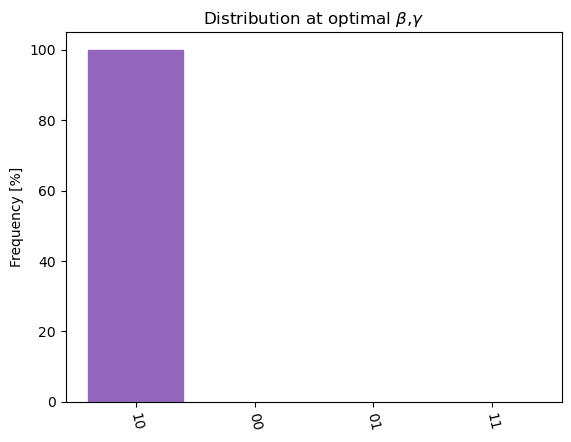

In [50]:
total_val = 0
for item in result_distribution.values():
    total_val += item
freqs_percent = {name:100*value/total_val for name,value in result_distribution.items()}
bit_string = list(freqs_percent.keys())
counts = list(freqs_percent.values())

top_5_values = sorted(counts, reverse=True)[:5]

positions = []
for i in range(len(counts)) :
    if counts[i] > 7:
     positions.append(i)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(bit_string,freqs_percent.values(),color="tab:grey")
for p in positions:
    ax.get_children()[p].set_color("tab:purple")


# Rotating X-axis labels
plt.xticks(rotation = -77)
plt.title(r'Distribution at optimal $\beta$,$\gamma$')
plt.ylabel('Frequency [%]')

In [52]:
#plt.hist(result_distribution)

# extract the top 3 values
n = 4
top_n_values=[] #(key,freq)


for item in result_distribution.items():

    top_n_values.append(item)
   
    top_n_values = sorted(top_n_values,key=lambda item: item[1], reverse = False)
    
    if len(top_n_values) > n:
        top_n_values.pop()

top = top_n_values[0]

top_n_cuts = [[],[]]
for solution, _ in top_n_values:
    top_n_cuts[0].append(solution)
    top_n_cuts[1].append(solution_value(solution))


Text(0, 0.5, 'Value of solution')

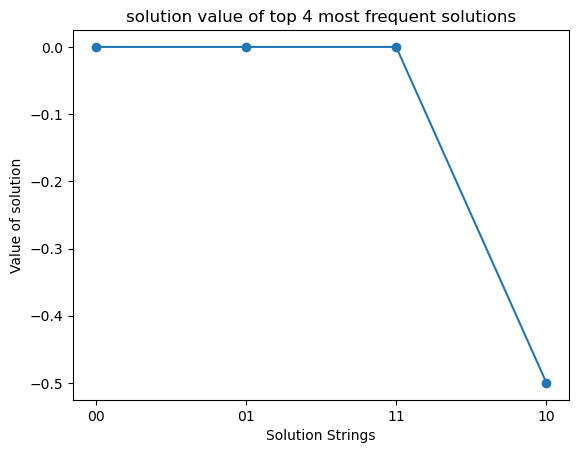

In [57]:
plt.plot(top_n_cuts[0],top_n_cuts[1],'o-')

plt.title(f'solution value of top {n} most frequent solutions')
plt.xlabel('Solution Strings')
plt.ylabel('Value of solution')